In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("cs109b_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 3: Artificial Neural Networks, Model Interpretation, and Regularization


**Harvard University**<br/>
**Spring 2023**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas

<hr style="height:2pt">

In [3]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [4]:
import random
random.seed(109)

import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# TensorFlow and tf.keras
import tensorflow as tf

from sklearn.impute import KNNImputer

2023-03-13 11:44:27.967112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# measure notebook runtime
time_start = time.time()

<hr>

#### Instructions
- To submit your assignment follow the instructions given in Canvas.
- Plots should be legible and interpretable without having to refer to the code that generated them, including labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you think the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so passing a test is necessary but not sufficient for full credit. 
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output.
- Feel free to add additional code or markdown cells as needed.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**

<hr>

<a id="contents"></a>

# Notebook Contents

- [**PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs**](#part1)
  - [Overview and Data Description](#part1intro)
  - [Questions](#part1questions)


- [**PART 2 [35 pts]: Kannada MNIST Kaggle competition**](#part2)
  - [Problem Statement](#part2intro)
  - [The Kannada MNIST Dataset](#part2about)
  - [Downloading the Data Files](#part2data)
  - [CS109B Kaggle Competition](#part2kaggle)
  - [Questions](#part2questions)


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 1 [65 pts]: Model interpretation and predictive intervals in ANNs

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview and Data Description

[Return to contents](#contents)

In this problem, you will be building and interpreting models to predict whether a flight was delayed for its arrival. The model will be based on features that can be measured as the flight takes off.

We will also estimate the predictive intervals of the model using bootstrapping. We will utilize those predictive intervals to build a new kind of model: a model that refrains from making a prediction when it is not confident.

The variable in the original csv are:

    
**ARRIVAL_DELAY**: the difference between scheduled arrival and actual arrival, in minutes (positive is late, negative is early).

**DISTANCE**: the distance between arrival and departure airports, in miles.

**SCHEDULED_TIME**: the flight's scheduled travel time in minutes.

**MONTH**: the month the flight took off, 1 = January, 2 = February, etc.

**SCHED_DEP_HOUR**: the scheduled departure time (the hour of the day).

**SCHED_ARR_HOUR**: the scheduled arrival time (the hour of the day).

**FLIGHT_COUNT**: the number of flights flying out of the origin airport before noon on a typical day.

**DAY_OF_WEEK**: the day of the week, 1 = Monday, 2 = Tuesday, etc.

**ORIGIN_AIRPORT**: the airport the flight took off from.

**DESTINATION_AIRPORT**: the airport the flight was scheduled to land at.

For the airport codes, see: https://www.bts.gov/topics/airlines-and-airports/world-airport-codes

To sucessfully complete this part, you will proceed by fitting a NN model, evaluating its accuracy, interpreting the predictors' importance, and finally evaluating the predictive intervals.

**NOTE:** the observations were sampled so that roughly half of the observations were delayed and half of the observations were not delayed.

<!-- </div> -->

<a id="part1solutions"></a>

## PART 1 Questions

[Return to contents](#contents)


<div class='exercise-r'>

**1.1**  **Preprocess the data**

Our first step will be to read in our dataset and preprocess our data.



</div>

<div class='exercise-r'>

**1.1.1**   Read in the dataset `data/flights.csv` into a DataFrame called `df_flights`. Create a new column in the DataFrame called `DELAY_OR_NOT`. This is a binary variable that denotes whether `ARRIVAL_DELAY` is greater-than-or-equal-to 15 minutes (the FAA and BTS define a flight as delayed by 15 minutes or more). This is going to be the response variable for the rest of part 1. 




</div>

In [5]:
# your code here 

df_flights = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Problem Sets/cs109b_hw3/data/flights.csv")

In [6]:
# your code here

delay = lambda x: 1 if x >= 15 else 0

df_flights['DELAY_OR_NOT'] = df_flights['ARRIVAL_DELAY'].map(delay)
df_flights = df_flights.drop('ARRIVAL_DELAY', axis=1)

In [7]:
grader.check("q1.1.1")

q1.1.1 results: All test cases passed!

<div class='exercise-r'>

**1.1.2 Preprocess the data**
    
- Deal with missing values if there are any
- One-hot-encode the non-numeric categorical variables
- Split the data using an 80/20 train-test split with `random_state=109` and stratifying on the response variable
- Standardize train and test with the scaler fit on the train data

Print the resulting shapes of your $X$ and $y$ dataframes for both your train and your test sets.
    
**NOTE:** While inspecting your data, you may notice that a large number of airport codes are recorded using 5-digit values instead of the expected 3-letter codes. That is perfectly fine. Those 5-digit values should be considered valid and just be treated the same as they would be if they were 3-letter codes.

**TIPS:** 
- month and day-of-the-week should be treated as numerical in this context.
- you should consider what predctors are acceptable to include given our goal is to predict if a flight is delayed.


</div>

We believe using KNNImputer may be a better alternative than dropping the rows to fill in the missing values as it is more interesting here to fill in these missing values using other features in the dataset rather than dropping them altogether. Also, it is particularly useful in cases where the missing data is in multiple features at once. 

This enables us to preserve the integrity and completeness of the original dataset, and it works very well in combination with other preprocessing techniques such as scaling, which we also use.  

In [8]:
# your code here

print(df_flights.isna().sum())

DISTANCE               5
SCHEDULED_TIME         1
MONTH                  0
SCHED_DEP_HOUR         0
SCHED_ARR_HOUR         0
FLIGHT_COUNT           5
DAY_OF_WEEK            0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
DELAY_OR_NOT           0
dtype: int64


In [9]:
# select rows with missing values
rows_with_missing_values = df_flights[df_flights.isnull().any(axis=1)]

# print the selected rows
print(rows_with_missing_values)

      DISTANCE  SCHEDULED_TIME  MONTH  SCHED_DEP_HOUR  SCHED_ARR_HOUR  \
70         NaN           395.0     11               6               9   
1566       NaN           418.0      2               6               9   
3741       NaN           419.0     11              11              15   
5612       NaN           381.0      6               8              12   
6375       NaN             NaN      7              18              21   

      FLIGHT_COUNT  DAY_OF_WEEK ORIGIN_AIRPORT DESTINATION_AIRPORT  \
70             NaN            1            BOS                 SFO   
1566           NaN            5            BOS                 SFO   
3741           NaN            2            BOS                 SFO   
5612           NaN            5            BOS                 SFO   
6375           NaN            3            BOS                 SFO   

      DELAY_OR_NOT  
70               0  
1566             0  
3741             0  
5612             0  
6375             1  


In [10]:
# one hot encode the categorical variable
df_flights = pd.get_dummies(df_flights, columns=['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])

In [11]:
# create KNNImputer object and fit to data
imputer = KNNImputer(n_neighbors=2)
imputer.fit(df_flights)

# transform data with imputed values
df_flights = pd.DataFrame(imputer.transform(df_flights), columns=df_flights.columns)

There is only a handful of missing values in the dataframe and its only in variables that we hypothesize do not matter that much. Hence, we can probably just drop them without loss. 

In [12]:
# We check which types our columns have
# Need to OHE 'ORIGIN_AIRPORT' and 'DESTINATION_AIRPORT'

df_flights.dtypes

DISTANCE                   float64
SCHEDULED_TIME             float64
MONTH                      float64
SCHED_DEP_HOUR             float64
SCHED_ARR_HOUR             float64
                            ...   
DESTINATION_AIRPORT_VLD    float64
DESTINATION_AIRPORT_VPS    float64
DESTINATION_AIRPORT_XNA    float64
DESTINATION_AIRPORT_YAK    float64
DESTINATION_AIRPORT_YUM    float64
Length: 811, dtype: object

In [13]:
# y = 'DELAY_OR_NOT'

# # split the data into training and testing sets
# df_train, df_test = train_test_split(df_flights, 
#                                      test_size=0.2, 
#                                      random_state=109, 
#                                      stratify=df_flights[y])

# y_train = pd.DataFrame(df_train[y])
# y_test = pd.DataFrame(df_test[y])

# df_train.drop(y, axis=1)
# df_test.drop(y, axis=1)

# # Fit standard scaler on the training data
# scaler = StandardScaler().fit(df_train)

# df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
# df_train_scaled['DELAY_OR_NOT'] = y_train

# df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
# df_test_scaled['DELAY_OR_NOT'] = y_test


In [14]:
# train test split
y = df_flights['DELAY_OR_NOT']
X = df_flights.drop('DELAY_OR_NOT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size=0.8, 
                                                    random_state=109)

#scaler
# fit on train and scale train and test
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# keep labels
predictors = list(X.columns)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("X_test shape:", y_test.shape)

X_train shape: (8000, 810)
y_train shape: (8000,)
X_test shape: (2000, 810)
X_test shape: (2000,)


<div class='exercise-r'>

**1.2**  **Fit an ANN**

Fit an artificial neural network model using all predictors (name this model `NN_model`).  Use a dense feed-forward network with two hidden layers with 15 nodes in each hidden layer. For this network, use a reasonable activation function for the hidden layers, select an appropriate loss function and optimizer, specify a validation split of 0.2, train for a reasonable number of epochs. Feel free to use tensorflow's default batch size while training. Plot the training accuracy and validation accuracy as a function of epochs from your `NN_model`'s training history. Evaluate the `NN_model` model on both train and test, and print out the resulting train and test accuracies.

**Hint:** You should base your choice of "a reasonable number of epochs" on the visualization of the model's training history.

<a id="q13"></a>



</div>

In [15]:
# build your NN 
# your code here

# extract the predictor variables and response variable 
# from the training and testing sets
#X_train = df_train_scaled.drop(y, axis=1)
#y_train = pd.DataFrame(df_train_scaled[y])
#X_test = df_test_scaled.drop(y, axis=1)
#y_test = pd.DataFrame(df_test_scaled[y])

# define the ANN model

n_hidden = 2
hidden_size = 15
batch_size = 128

NN_model = tf.keras.Sequential()
NN_model.add(tf.keras.Input(shape=X_train.shape[1]))
for i in range(n_hidden):
    NN_model.add(tf.keras.layers.Dense(hidden_size, activation='relu'))
NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


2023-03-13 10:37:05.427385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                12165     
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 12,421
Trainable params: 12,421
Non-trainable params: 0
_________________________________________________________________


In [17]:
# compile it and run it
# your code here 
# compile the model

NN_model.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['accuracy'])

In [18]:
# plot train and val acc as a function of epochs
# your code here

# fit the model to the training data
history = NN_model.fit(X_train, y_train, epochs=6, batch_size=32, validation_split=0.2)

Epoch 1/6
200/200 [==============================] - 1s 3ms/step - loss: 0.6957 - accuracy: 0.5895 - val_loss: 0.6529 - val_accuracy: 0.6131
Epoch 2/6
200/200 [==============================] - 0s 2ms/step - loss: 0.5907 - accuracy: 0.6916 - val_loss: 0.6090 - val_accuracy: 0.6819
Epoch 3/6
200/200 [==============================] - 0s 1ms/step - loss: 0.5240 - accuracy: 0.7402 - val_loss: 0.6128 - val_accuracy: 0.6950
Epoch 4/6
200/200 [==============================] - 0s 1ms/step - loss: 0.4909 - accuracy: 0.7656 - val_loss: 0.6281 - val_accuracy: 0.7006
Epoch 5/6
200/200 [==============================] - 0s 1ms/step - loss: 0.4713 - accuracy: 0.7759 - val_loss: 0.6424 - val_accuracy: 0.7013
Epoch 6/6
200/200 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.7819 - val_loss: 0.6458 - val_accuracy: 0.7088


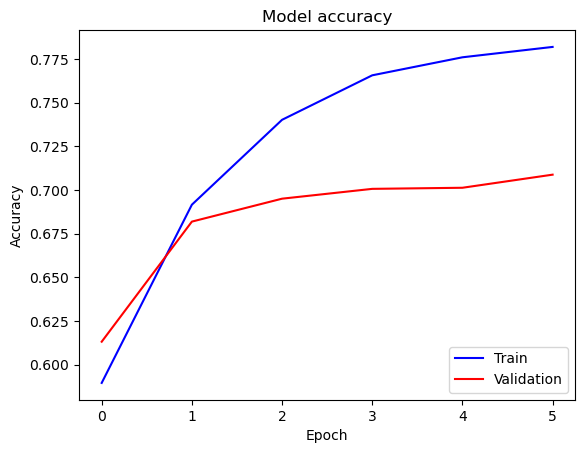

In [19]:
# evaluate on train and test and print accuracy results
# your code here 

# plot the training and validation accuracy as a function of epochs
plt.plot(history.history['accuracy'], color='blue')
plt.plot(history.history['val_accuracy'], color='red')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [20]:
# evaluate the model on the training data
train_loss, train_acc = NN_model.evaluate(X_train, y_train)
print('Train accuracy:', train_acc)

# evaluate the model on the test data
test_loss, test_acc = NN_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

250/250 [==============================] - 0s 1ms/step - loss: 0.4713 - accuracy: 0.7844
Train accuracy: 0.784375011920929
63/63 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.6960
Test accuracy: 0.6959999799728394


<div class='exercise-r'>

**1.3**  **Fit and examine a "proxy" model**

Neural networks are often called 'black-box' models because it is difficult to interpret just what role each feature plays in the predictions they output. But suppose we choose a second type of model which is easier to interpret and train it to *predict the predictions* of the`NN_model`. That is, the response variable for the second, "proxy" model is the set of predictions generated by the `NN_model`, $\hat{y}$, **not** the true values, $y$. Interpreting this second, "proxy" model can then give us some insight into how the `NN_model` is making its predictions.




</div>

<div class='exercise-r'>

**1.3.1**  First, generate a set of `NN_model` class predictions for the training set. Call these `y_train_nn`. These $\hat{y}$ training predictions will be used instead of the true $y$ training values when we fit our proxy model in 1.3.2. The $X$ values used in our 1.3.2 proxy model should be the same ones used for `NN_model`.




</div>

In [21]:
# your code here
y_train_nn = (NN_model.predict(X_train) > 0.5).astype("int32")

250/250 [==============================] - 0s 860us/step


In [22]:
grader.check("q1.3.1")

q1.3.1 results: All test cases passed!

<div class='exercise-r'>

**1.3.2**  Next, fit a logistic regression model using your $\hat{y}$ values from 1.3.1 (name this model `logreg`). Use ridge-like regularization. Next, print the `logreg` test accuracy compared to the *true $y$ values* to confirm that it is similar to what we saw for our `NN_model` test accuracy in 1.2. You may need to adjust `C` in order to achieve a similar accuracy.




</div>

In [23]:
from sklearn.linear_model import LogisticRegressionCV

In [24]:
# # define a range of C values to test
# c_values = [0.0001, 0.001, 0.01, 0.5, 0.1, 0.2, 0.3]

# # create a logistic regression object
# logregcv = LogisticRegressionCV(Cs=c_values, penalty='l2', max_iter=1000)

# # fit the logistic regression model to the training data
# logregcv.fit(X_train, y_train_nn)

# # get the best C value found by cross-validation
# best_C = logregcv.C_[0]

In [25]:
# your code here

logreg = LogisticRegression(penalty = 'l2', 
                            C=0.2, max_iter=1000).fit(X_train, y_train_nn.ravel())


print("Logistic regression Test Accuracy: {:.2f}%".format(logreg.score(X_test, y_test)*100))
print("Previous Test Accuracy: {:.2f}%".format(test_acc*100))

Logistic regression Test Accuracy: 70.70%
Previous Test Accuracy: 69.60%


<div class='exercise-r'>

**1.3.3**  Now use sklearn's `permutation_importance` function (already included in this notebook's imports) to compute the feature importance using the `logreg` model. Plot the **relative** feature importance (normalizing your importances so that your largest importance equals 1 for comparison purposes) for the top-10 most important predictors identified by the `permutation_importance` function.

  - Please refer to sklearn's official documentation to learn how this function works.
  
  - When running `permutation_importance` for this problem, you can use the default number of `n_repeats` and your estimator's default `scorer`. To speed up the time it takes to run your permutations, you can try setting `n_jobs=-1` to take full advantage of all of your available processor cores.

<a id="q14"></a>



</div>

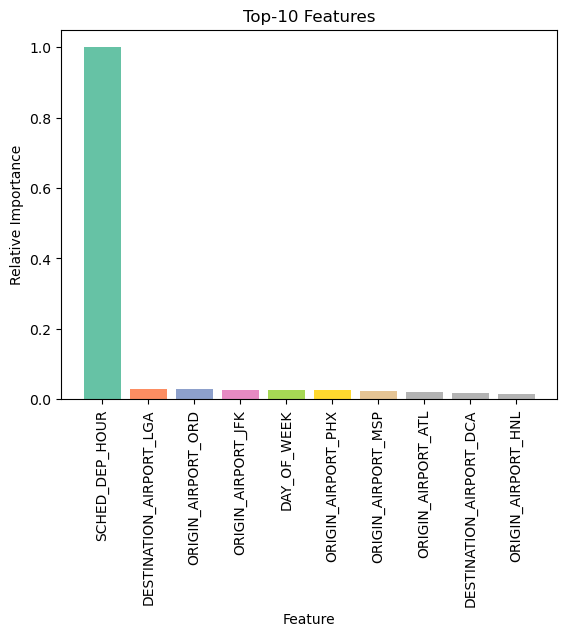

CPU times: user 3.35 s, sys: 521 ms, total: 3.87 s
Wall time: 47.7 s


In [26]:
%%time
# Compute permutation-based feature importances
result = permutation_importance(logreg, 
                                X_test, 
                                y_test, 
                                n_repeats=10, 
                                random_state=0, 
                                n_jobs=-1)

importances = result.importances_mean

# Find indices of top-10 features
top_n = 10
idx = np.argsort(importances)[::-1][:top_n]

# Normalize importances and create color map
norm_imp = importances / importances.max()
colors = plt.cm.Set2(np.arange(top_n))

# Create bar plot with different colors for top features
plt.bar(range(top_n), norm_imp[idx], color=colors)
plt.xticks(range(top_n), X_train.columns[idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Relative Importance')
plt.title('Top-10 Features')
plt.show()

<div class='exercise-r'>

**1.4**  **Visualize important features** 

Another way to interpret the  `NN_model` is by examining the response as a function of any of the predictors. Particularly, we will select from features often found most significant from the analysis above. Though the data has been scaled, **for all plots in 1.4, please visualize using the original scale for interpretability.**

**NOTE:** The predictors you are required to use in 1.4 may differ from some of the top-10 predictors you identified in 1.3 as a result of random variability in our algorithms.




</div>

<div class='exercise-r'>

**1.4.1**
    
Set all predictors to their means/modes except for `SCHED_DEP_HOUR` (when deciding between mean and mode, consider whether a given predictor is continous or categorical.
    
Next, predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. `SCHED_DEP_HOUR` on the data from the **training set**. Interpret what you see in 2-4 sentences.

**NOTE:** Again, the values of `SCHED_DEP_HOUR` used her for predictions and plotting should be those actually *observed* in the training data.


</div>

The plot above indicates that the probability of delay increases in a nearly linear manner as the scheduled departure hour advances. This finding supports the previous plot, which emphasized the significance of this predictor over others. Moreover, the observation aligns with the intuition that departure hour is a key factor influencing delays.

In [27]:
relevant_predictors = ['SCHED_DEP_HOUR']

continuous_pred = ['DISTANCE', 
                   'SCHEDULED_TIME', 
                   'MONTH',
                   'SCHED_ARR_HOUR', 
                   'FLIGHT_COUNT', 
                   'DAY_OF_WEEK']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscaled training data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 818us/step


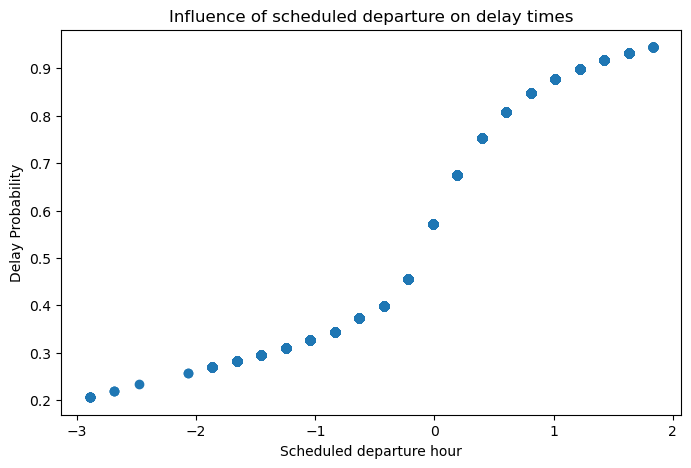

In [28]:
# prediction

delay_prob = NN_model.predict(X_temp)


plt.figure(figsize=(8, 5))
plt.scatter(X_temp['SCHED_DEP_HOUR'], delay_prob)
plt.title('Influence of scheduled departure on delay times')
plt.xlabel('Scheduled departure hour')
plt.ylabel('Delay Probability')
plt.show()

<div class='exercise-r'>

**1.4.2**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `FLIGHT_COUNT`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values `SCHED_DEP_HOUR` and `FLIGHT_COUNT` observed in the training set.  
    
**NOTE:** See hint in 1.4.5 about plotting in this section




</div>

In [29]:
# your code here
relevant_predictors = ['SCHED_DEP_HOUR', 'FLIGHT_COUNT']

continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 
                   'MONTH','SCHED_ARR_HOUR', 
                   'DAY_OF_WEEK']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscaled training data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 765us/step


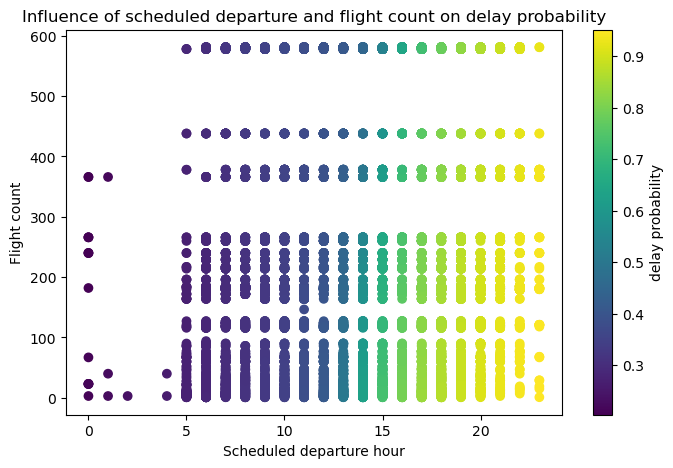

In [30]:
# your code here

# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['FLIGHT_COUNT'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Flight count')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()



<div class='exercise-r'>

**1.4.3**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `SCHED_ARR_HOUR` observed in the training set.




</div>

In [31]:
# your code here
relevant_predictors = ['SCHED_DEP_HOUR', 'SCHED_ARR_HOUR']

continuous_pred = ['DISTANCE', 'SCHEDULED_TIME', 
                   'MONTH','FLIGHT_COUNT', 
                   'DAY_OF_WEEK']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()


for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscaled training data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 757us/step


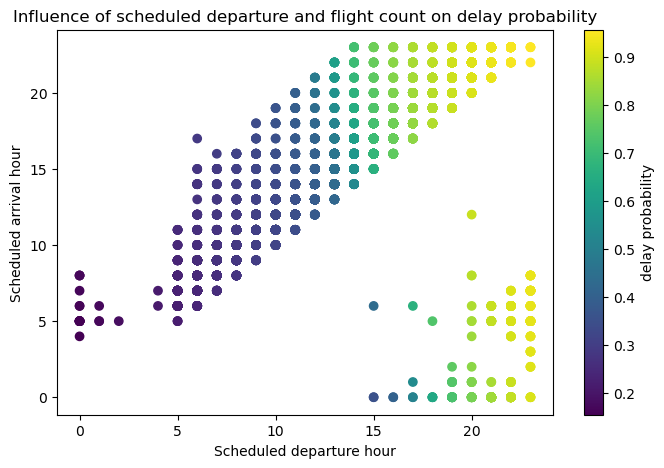

In [32]:
# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['SCHED_ARR_HOUR'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Scheduled arrival hour')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.4**  Set all predictors to their means/modes except for `SCHED_DEP_HOUR` and `DISTANCE`. Predict the `NN_model` probability of delay and plot the predicted probabilities of delay vs. values of `SCHED_DEP_HOUR` and `DISTANCE` observed in the training set. 




</div>

In [33]:
# your code here

relevant_predictors = ['SCHED_DEP_HOUR', 'DISTANCE']

continuous_pred = ['SCHEDULED_TIME', 
                   'MONTH','SCHED_ARR_HOUR', 
                   'DAY_OF_WEEK', 'FLIGHT_COUNT']

categorical_pred = list(set(X_train.columns) - set(continuous_pred) - set(relevant_predictors))

X_temp = X_train.copy()

for col in X_temp.columns:
    if col in continuous_pred:
        X_temp[col].values[:] = X_temp[col].mean()
    if col in categorical_pred:
        X_temp[col].values[:] = X_temp[col].mode()
        
# Unscaled training data
X_temp_unscaled = pd.DataFrame(scaler.inverse_transform(X_temp), columns=X.columns)

250/250 [==============================] - 0s 764us/step


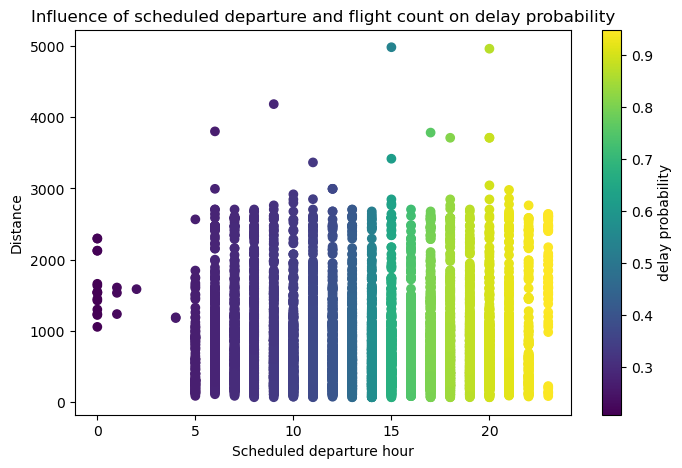

In [34]:
# prediction

delay_prob = NN_model.predict(X_temp)

fig, ax = plt.subplots(figsize=(8, 5))
scat = ax.scatter(X_temp_unscaled['SCHED_DEP_HOUR'],X_temp_unscaled['DISTANCE'], c=delay_prob)
ax.set_title('Influence of scheduled departure and flight count on delay probability')
ax.set_xlabel('Scheduled departure hour')
ax.set_ylabel('Distance')
fig.colorbar(scat, pad=0.05, label='delay probability')
plt.show()

<div class='exercise-r'>

**1.4.5**  In 5-10 sentences, interpret what you have seen in 1.4.2, 1.4.3, and 1.4.4.

**HINT:** For 1.4.2, 1.4.3, and 1.4.4, when you include `SCHED_DEP_HOUR` on one axis and your second predictor on the other axis, you can color your data points based on their corresponding predicted probabilities by using  the `c` and `cmap` arguments in `plt.scatter`. You can also add a labeled colorbar to your plot to make clear what those colors mean. You can refer to the [matplotlib documentation](https://matplotlib.org/stable/tutorials/index) for examples. This [stackoverflow post](https://stackoverflow.com/questions/17682216/scatter-plot-and-color-mapping-in-python) covering color mapping with scatter plots may also be useful. 

<a id="q15"></a>



</div>

_Type your answer here, replacing this text._

<div class='exercise-r'>

**1.5**  **Bootstrap prediction intervals**

In this part, we will attempt to do model inference. Neural Networks have too many parameters, and therefore inference on all the parameters is intractable and meaningless. 

Using the same network architecture as `NN_model` (layers, nodes, activations, etc.) and your scaled data from that model, create multiple training sets using bootstrapping and fit a separate neural network model to each bootstrapped set of data (the number of bootstraped *datasets*, $n$, should be at least 50). For each of the $n$ models, make predictions on the test data. Randomly select 8 test observations and on 8 subplots, plot the distribution of the $n$ predicted probabilities with the 95% prediction intervals clearly marked and reported in each subplot and the **actual** class of each observation included in each subplot's title for easy reference.
    
Interpret what you see in 3-5 sentences.

**NOTE:** The code for this problem can take an extremely long time to execute. Please feel free to use the `progressbar` function provided below to visually track the progress of your bootstraps.

<a id="q16"></a>



</div>

In [35]:
def progressbar(n_step, n_total):
    """Prints self-updating progress bar to stdout to track for-loop progress
    
    There are entire 3rd-party libraries dedicated to custom progress-bars.
    A simple function like this is often more than enough to get the job done.
    
    :param n_total: total number of expected for-loop iterations
    :type n_total: int
    :param n_step: current iteration number, starting at 0
    :type n_step: int

    .. example::
    
        for i in range(n_iterations):
            progressbar(i, n_iterations)
            
    .. source:
    
        This function is a simplified version of code found here:
        https://stackoverflow.com/questions/3160699/python-progress-bar/15860757#15860757
    """
    n_step = n_step + 1
    barlen = 50
    progress = n_step / n_total
    block = int(round(barlen * progress))
    status = ""
    if n_step == n_total:
        status = "Done...\r\n\n"
    text = "\r [{0}] {1}/{2} {3}".format(
        "=" * block + "-" * (barlen - block),
        n_step,
        n_total,
        status,
    )
    sys.stdout.write(text)
    sys.stdout.flush()

_Type your answer here, replacing this text._

In [36]:
# extract the predictor variables and response variable 
# from the training and testing sets
# X_train = df_train_scaled.drop(y, axis=1)
# y_train = pd.DataFrame(df_train_scaled[y])
# X_test = df_test_scaled.drop(y, axis=1)
# y_test = pd.DataFrame(df_test_scaled[y])

In [37]:
%%time
# Bootstrap and train your networks and get predictions on X test
# your code here

# NN model for bootstrap
n_bootstrap = 75

bootstap_preds = []

for k in range(n_bootstrap):
    progressbar(k, n_bootstrap)
    # build NN
    NN_boot = tf.keras.Sequential()
    for i in range(n_hidden):
        NN_boot.add(tf.keras.layers.Dense(hidden_size, activation='sigmoid'))
    NN_boot.add(tf.keras.layers.Dense(1, activation='relu'))
    #sample
    sample_idx = np.random.choice(X_train.index, size=len(X_train.index))
    X_sample = X_train.iloc[sample_idx]
    y_sample = y_train.iloc[sample_idx]

    # compile + fit
    NN_boot.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    NN_boot.fit(X_sample, y_sample, batch_size=32, epochs=10, validation_split=0.2, verbose=0)
    y_sample_pred = NN_boot.predict(X_test)
    bootstap_preds.append(y_sample_pred)

63/63 [==============================] - 0s 788us/step74/7
 [==================================================] 75/75 Done...

63/63 [==============================] - 0s 844us/step
CPU times: user 5min 12s, sys: 34.4 s, total: 5min 46s
Wall time: 4min 32s


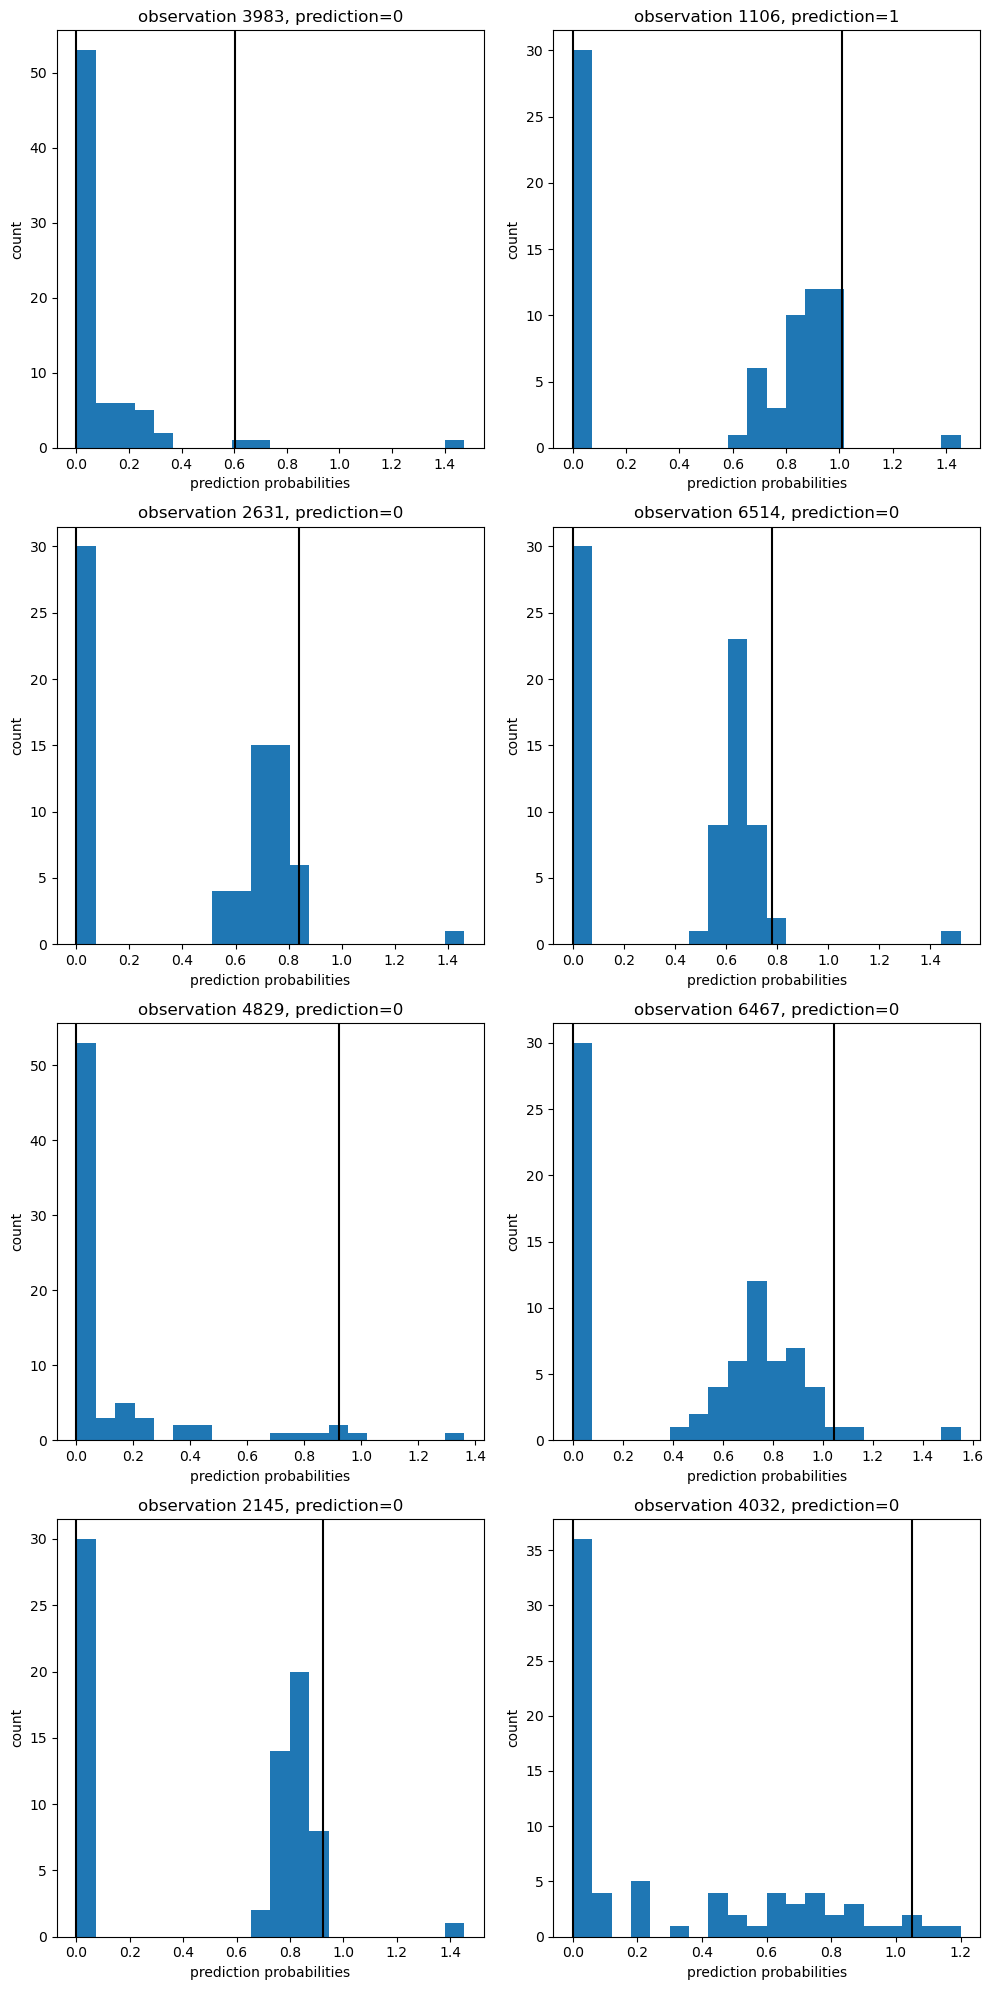

In [38]:
# generate your plot
# your code here

bootstap_preds = np.array(bootstap_preds).reshape(n_bootstrap, X_test.shape[0])
obs = [np.random.randint(X_train.shape[0]) for i in range(8)]

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(10, 20))
axs = axs.flatten()
for i, o in enumerate(obs):
    obs_pred = bootstap_preds[:, i]
    # take bootstrap mean for prediction
    res = 1*(np.mean(obs_pred)>0.5)
    axs[i].hist(obs_pred, bins=20)
    axs[i].axvline(np.quantile(obs_pred, 0.025), color='black')
    axs[i].axvline(np.quantile(obs_pred, 0.975), color='black')
    axs[i].set_xlabel("prediction probabilities")
    axs[i].set_ylabel("count")
    axs[i].set_title("observation {}, prediction={}".format(o, res))
plt.tight_layout()
plt.show()

<div class='exercise-r'>

**1.6**  **Build an "abstain" bagging model**

Using the probability distribution of the predictions obtained from the bootstrapped samples above, we can evaluate how confident we should be in our bagged (i.e. bootstrap-aggregated) predictions for each test observation.

To accomplish this, you will first calculate a metric we'll call the **Posterior Prediction Dissent (PPD)** related to the proportion of predictions a given test observation receives for the minority opinion. Some examples: if 10% of the bootstrapped models predict $\hat{y} = 0$ with the remaining 90% predicting $\hat{y}=1$, then the $PPD=0.1$. When a bagged prediction's $PPD=0$, all predictions are compatible (i.e. all bootstrapped probabilities for that test observation are on the same side of $\hat{p}=0.5$). Likewise, when the $PPD=0.5$, half of the bootstrapped predictions for that test observation are $\hat{y}=0$, and the other half are $\hat{y}=1$. After calculating your $PPD$ values for all test observations, you should have $n=2000$ $PPD$ values (i.e. one for each test observation).

Next, to get more accurate predictions, we can create an **abstain** model that will abstain from making a prediction for a particular observation if some defined threshold for lack-of-confidence (i.e. maximum permissible $PPD$ value) is crossed. (If you'd like to learn more about abstain models, you can read more [here](https://openreview.net/forum?id=rJxF73R9tX).)

Let's explore how your resulting test accuracies might change by using your bootstrapped prediction results from question 1.5 for an **abstain bagging model** (i.e. a bootstrap aggregated model where some test observations are simply not predicted based on a given $PPD$ threshold). You can make your abstain model *stricter* by using smaller $PPD$ threshold values.

- Print the test accuracy for your **bagging model** predictions from question 1.5 using predictions for all 2,000 of our test observations. 

- Plot the test accuracies for an **abstain bagging model** using your predictions from question 1.5 as a function of increasing $PPD$.

- Also, plot the proportion of test observations not abstained (i.e. the proportion of those predicted) for your **abstain bagging model** as a function of increasing $PPD$.

- Interpret what you see in 3-5 sentences.

**NOTE**: You should observe that as $PPD$ decreases (more confident predictions), you must also compromise on the number of points that your abstain model is permitted to predict on. 

**HINT:** 
- What is the range of values PPD can take on? Is it the same as the range of our predictions themselves?
- When calculating accuracies, you should only consider those observations that received predictions (i.e., not the abstained observations)
</div>

_Type your answer here, replacing this text._

In [39]:
(220*(1/2)**9*(1/2)**3)

0.0537109375

In [40]:
y_test_pred = (NN_model.predict(X_test) > 0.5).astype("int32")
y_test_pred = np.argmax(y_test_pred, axis=1)

63/63 [==============================] - 0s 794us/step


Test bagging accuracy: 0.860


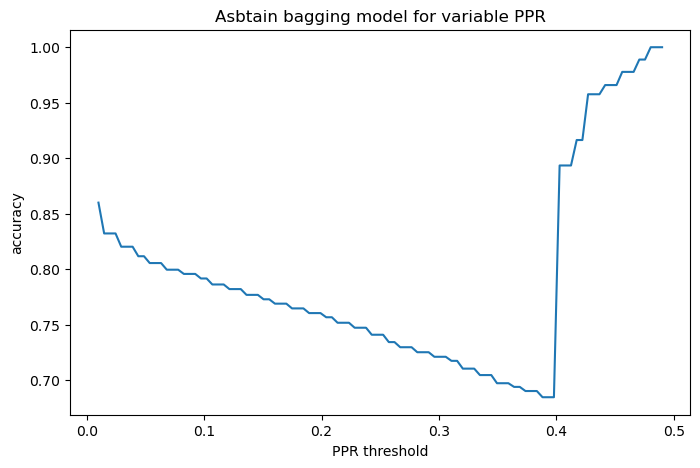

In [41]:
# your code here

v0 = np.sum(bootstap_preds<0.5, axis=0)
v1 = n_bootstrap - v0
v = np.stack((v0, v1))
PPR = np.min(v, axis=0)/n_bootstrap

bagg_pred = 1*(np.mean(bootstap_preds, axis=0)>0.5)
bagg_acc = accuracy_score(y_test_pred, bagg_pred)

y_test_pred = y_test_pred.flatten()
pred = 1*(np.mean(bootstap_preds, axis=0)>0.5)

print("Test bagging accuracy: {:.3f}".format(bagg_acc))
thresh = np.linspace(0.01, .49, 100)
kept = []
abs_bagg_acc = []

for t in thresh:
    to_keep = PPR>t
    kept.append(np.sum(to_keep))
    acc = accuracy_score(y_test_pred[to_keep], pred[to_keep])
    abs_bagg_acc.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(thresh, abs_bagg_acc)
plt.xlabel("PPR threshold")
plt.ylabel("accuracy")
plt.title("Asbtain bagging model for variable PPR")
plt.show()

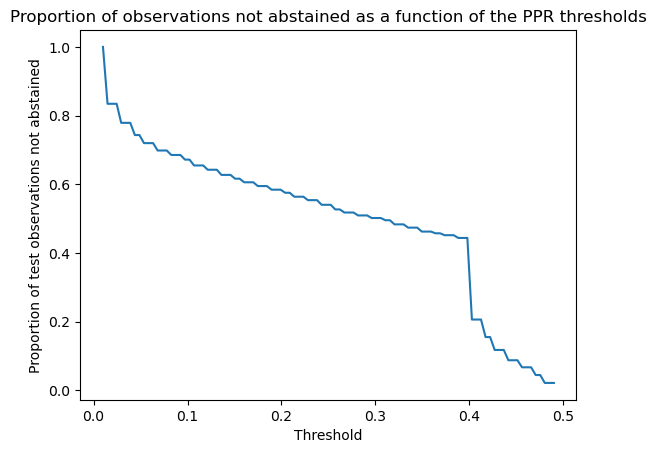

In [42]:
# your code here
plt.plot(thresh,np.array(kept)/len(y_test))
plt.xlabel("Threshold")
plt.ylabel("Proportion of test observations not abstained")
plt.title("Proportion of observations not abstained as a function of the PPR thresholds")
plt.show()

In [43]:
# your code here
...

<a id="part2"></a>

<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# PART 2 [35 pts]: Kannada MNIST Kaggle competition

[Return to contents](#contents)


<a id="part2intro"></a>

## Problem Statement

[Return to contents](#contents)


Artificial neural networks (ANNs) can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns do not generalize to new data.

There are several methods used to improve ANN generalization. 

One approach is to use an architecture just barely wide or deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and it is computationally costly to hunt for the correct size. Given this, other methodologies are used to prevent overfitting and improve ANNs' generalizability. These methodologies, like other techniques that combat overfitting, fall under the umbrella term of "regularization".

In this problem, you are asked to regularize a network of a given architecture.

<a id="part2about"></a>

## The Kannada MNIST Dataset

[Return to contents](#contents)


![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F1e01bcc28b5ccb7ad38a4ffefb13cde0%2Fwondu.png?generation=1603204077179447&alt=media)


For this problem, we will be working with a modified version of the [Kannada MNIST dataset](https://arxiv.org/pdf/1908.01242.pdf), which is a large database of handwritten digits in the indigenous language *Kannada*.

This dataset consists of 60,000 28x28 grayscale images of the ten digits, along with a test set of 10,000 images. 

For this homework, we will simplify the problem by only using the digits labeled `0` and `1` owing to the similarity of the two symbols, and we will use a total of 1,200 samples for training (this includes the data you will use for validation).

To understand the dataset better, we recommend this [article](https://towardsdatascience.com/a-new-handwritten-digits-dataset-in-ml-town-kannada-mnist-69df0f2d1456) by Vinay Prabhu, the curator of the dataset.

<a id="part2data"></a>

## Downloading the Data Files

[Return to contents](#contents)


**Please download the specific `kmnist_train.csv` and `kmnist_test.csv` data files available on [the "Data" tab of the CS109B HW3 Kaggle Competition website](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). (DO NOT USE DATA FROM ANY OTHER SOURCE!)**

Here's a brief description of the data files:

- `kmnist_train.csv` is our training dataset and the last column contains our response class. The 784 other columns correspond to the pixel values of the 28x28 dimension image. Class 0 means a sample is the handwritten digit `0` and class 1 means a sample is the handwritten digit `1` in the Kannada written language. `kmnist_train.csv` has 1,200 samples.


- `kmnist_test.csv` has a structure similar to `kmnist_train.csv`, however the class label column is NOT included in with the test set. `kmnist_test.csv` has 2,000 samples. 


Kaggle leaderboard scores are accuracy scores calculated by Kaggle when you upload your predictions on this test set.

- `sample_submission.csv` is the format that kaggle will accept. The uploaded `.csv` must contain 2 columns. The first column must be named `id` and needs to contain the test observation index numbers for each prediction, the second must be named `category` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. 

<a id="part2kaggle"></a>

## CS109B Kaggle Competition

[Return to contents](#contents)

**ACCESS AND JOIN THE COMPETITION**:

**You need to create an account on Kaggle and [join the competition via this link](https://www.kaggle.com/t/91152696a0cf4872adedafbaff0f7f15). This is a limited participation competition. Please DO NOT share this link.**

**For more information on the rules** governing this CS109B Kaggle competition, please see below and also review [the modelling restrictions DOS and DON'TS outlined in question 2.3.1](#q2.3.1).

**IMPORTANT NOTES ABOUT SCORING**:

- The **public leaderboard** on Kaggle displays your performance on only 30% of the test set.


- After the competition is complete, the **private leaderboard** will show your performance on the remaining 70% of the test set.

- Question 2.3.5 is worth 5 points (the entire notebook is scored out of 100). Points for this questions will be awarded based on the **private leaderboard** as follows.

|Private Leaderboard Score   | Points|
|----------------------------|-------|
|$0.945 \leq \text{score}$ |5|
|$0.944 \leq \text{score} \lt 0.945$|4|
|$0.93 \leq \text{score} \lt 0.94$|3|
|$0.92 \leq \text{score} \lt 0.93$|2|
|$0.889 \leq \text{score} \lt 0.92$|1|

**🏆 Grand Prize(s):** The **Top-4** students on the private leaderboard will win an invitation to dinner with Pavlos and some of the CS109B teaching staff. This refers to the top 4 individuals on the board. The invitation will be extended to 5 students if the restriction to 4 would otherwise divide a group (e.g., 3 single submissions at the top followed by a group of 2).

**ADDITIONAL COMPETITION RULES:**

- Multiple Kaggle submissions are permitted (with a maximum of 20 submissions per-participant per-day), **just note that you will need to choose, on Kaggle, the ONE single submission to use for final scoring prior to the final HW3 submission deadline**, and **your submitted notebook MUST contain the matching code and model that generated your ONE chosen submission.**


- **To repeat this point, the version of your final HW3 notebook submitted on Canvas MUST contain the same code and exact same model used to generate your ONE chosen Kaggle submission.** (TFs may rerun your notebook code to ensure comparable final leaderboard results.)


- **Please do not manually label your submissions.** In other words, the labels should only be the outcome of your model.


- **No external data are allowed, you MUST USE ONLY the KMNIST training and test data downloaded via the "Data" tab of [the CS109B competition page linked above](#part2data).**


- **Do not** create multiple accounts on Kaggle.


<div class='exercise-r'>

**2.1**  **Get and visualize the data**

- Download the train and test data from [the competition page](#part2data).
- We will utilize `kmnist_test.csv` in question 2.3.4 only. 
- Load the data and use the matplotlib function `imshow` to display a handwritten 0 and a handwritten 1 from the training set.
- You are responsible for any preprocessing you deem necessary to help in your prediction task.

<a id="q22"></a>



</div>

In [6]:
# your code here
df_train = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_train.csv")
df_test = pd.read_csv("/Users/jamesliounis/Documents/Harvard SM DS/AC209b/Data/kmnist_test.csv")

In [7]:
# your code here
x_train, y_train = df_train.drop(["output"],axis=1), df_train["output"]
x_test = df_test

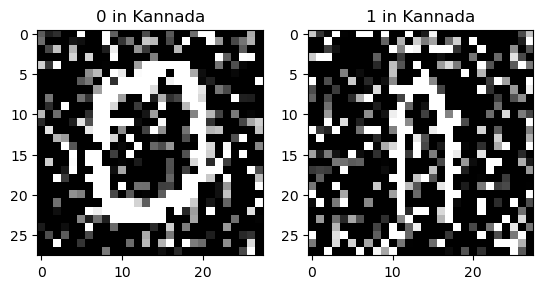

In [8]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(x_train.loc[2].values,(28,28)),cmap="gray")
ax[0].set_title("0 in Kannada")
#plt.savefig(path+'kmnist_train.jpg', dpi=300, format='jpg', bbox_inches='tight')
ax[1].imshow(np.reshape(x_train.loc[0].values,(28,28)),cmap="gray")
ax[1].set_title("1 in Kannada")
#plt.savefig(path+'kmnist_train.jpg', dpi=300, format='jpg', bbox_inches='tight')
plt.show()

<div class='exercise-r'>

**2.2**  **Overfit an ANN** 

Build and fit a fully-connected network (FCN) with the architecture given below using `tensorflow.keras` and assign it to a variable called `model_overfit`:

- Number of hidden layers: 3
- Nodes per hidden layer: 100, 100, 100
- Activation function: ReLU 
- Loss function: binary_crossentropy
- Output unit: Sigmoid 
- Optimizer: adam (use the defaults; no other tuning)
- Epochs: 1,000
- Batch size: 128
- Validation size: 0.3

![diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3630446%2F6a491ff8d4ff590dc8ded9a25461cd4b%2FScreenshot%202020-10-20%20at%209.42.36%20PM.png?generation=1603210420701577&alt=media) 
    
This ANN, when trained on the dataset, will overfit to the training set. Plot the training accuracy and validation accuracy (the x-axis should represent the number of epochs, and the y-axis should represent the accuracy). Explain how you can tell the model is overfitting. 




</div>

**Answer to Q2.2**

One can observe that the model is overfitting when the training accuracy reaches 100% and stops changing after just a few epochs. Additionally, the validation accuracy remains relatively low and remains nearly constant after approximately 300 epochs.

In [9]:
# your code here
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model_overfit = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
#model_overfit.summary()
model_overfit.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

2023-03-13 11:44:54.930377: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
%%time 
# your code here
N_eps = 1000
history=model_overfit.fit(x_train,y_train,epochs=N_eps,
                          batch_size=128,
                          validation_split=0.3)

Epoch 1/1000
7/7 [==============================] - 1s 42ms/step - loss: 9.2724 - accuracy: 0.5083 - val_loss: 3.0016 - val_accuracy: 0.5333
Epoch 2/1000
7/7 [==============================] - 0s 10ms/step - loss: 1.8518 - accuracy: 0.6357 - val_loss: 1.1178 - val_accuracy: 0.6806
Epoch 3/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.9681 - accuracy: 0.7238 - val_loss: 0.7025 - val_accuracy: 0.7583
Epoch 4/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.6698 - accuracy: 0.7798 - val_loss: 0.5517 - val_accuracy: 0.8222
Epoch 5/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.5412 - accuracy: 0.8155 - val_loss: 0.4973 - val_accuracy: 0.8222
Epoch 6/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.4099 - accuracy: 0.8476 - val_loss: 0.4663 - val_accuracy: 0.8333
Epoch 7/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.3126 - accuracy: 0.8810 - val_loss: 0.4345 - val_accuracy: 0.8194
Epoch 8/1000
7/7 

7/7 [==============================] - 0s 8ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3918 - val_accuracy: 0.9056
Epoch 60/1000
7/7 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3892 - val_accuracy: 0.9056
Epoch 61/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.3902 - val_accuracy: 0.9056
Epoch 62/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3946 - val_accuracy: 0.9056
Epoch 63/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3923 - val_accuracy: 0.9056
Epoch 64/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.3957 - val_accuracy: 0.9056
Epoch 65/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.3959 - val_accuracy: 0.9056
Epoch 66/1000
7/7 [========

7/7 [==============================] - 0s 6ms/step - loss: 2.4554e-04 - accuracy: 1.0000 - val_loss: 0.4525 - val_accuracy: 0.9083
Epoch 116/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.3593e-04 - accuracy: 1.0000 - val_loss: 0.4556 - val_accuracy: 0.9083
Epoch 117/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.3021e-04 - accuracy: 1.0000 - val_loss: 0.4560 - val_accuracy: 0.9083
Epoch 118/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2437e-04 - accuracy: 1.0000 - val_loss: 0.4559 - val_accuracy: 0.9083
Epoch 119/1000
7/7 [==============================] - 0s 6ms/step - loss: 2.2073e-04 - accuracy: 1.0000 - val_loss: 0.4571 - val_accuracy: 0.9083
Epoch 120/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.1421e-04 - accuracy: 1.0000 - val_loss: 0.4597 - val_accuracy: 0.9083
Epoch 121/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.1288e-04 - accuracy: 1.0000 - val_loss: 0.4608 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 8.4051e-05 - accuracy: 1.0000 - val_loss: 0.5088 - val_accuracy: 0.9083
Epoch 172/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.2478e-05 - accuracy: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.9083
Epoch 173/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.1470e-05 - accuracy: 1.0000 - val_loss: 0.5094 - val_accuracy: 0.9056
Epoch 174/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.0027e-05 - accuracy: 1.0000 - val_loss: 0.5111 - val_accuracy: 0.9083
Epoch 175/1000
7/7 [==============================] - 0s 7ms/step - loss: 7.9015e-05 - accuracy: 1.0000 - val_loss: 0.5118 - val_accuracy: 0.9083
Epoch 176/1000
7/7 [==============================] - 0s 7ms/step - loss: 7.7504e-05 - accuracy: 1.0000 - val_loss: 0.5131 - val_accuracy: 0.9083
Epoch 177/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.6261e-05 - accuracy: 1.0000 - val_loss: 0.5133 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 3.9194e-05 - accuracy: 1.0000 - val_loss: 0.5474 - val_accuracy: 0.9083
Epoch 228/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.8806e-05 - accuracy: 1.0000 - val_loss: 0.5478 - val_accuracy: 0.9083
Epoch 229/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.8346e-05 - accuracy: 1.0000 - val_loss: 0.5489 - val_accuracy: 0.9083
Epoch 230/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.7836e-05 - accuracy: 1.0000 - val_loss: 0.5496 - val_accuracy: 0.9083
Epoch 231/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.7370e-05 - accuracy: 1.0000 - val_loss: 0.5506 - val_accuracy: 0.9083
Epoch 232/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.6941e-05 - accuracy: 1.0000 - val_loss: 0.5509 - val_accuracy: 0.9083
Epoch 233/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.6525e-05 - accuracy: 1.0000 - val_loss: 0.5515 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 2.1359e-05 - accuracy: 1.0000 - val_loss: 0.5794 - val_accuracy: 0.9056
Epoch 284/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.1153e-05 - accuracy: 1.0000 - val_loss: 0.5799 - val_accuracy: 0.9083
Epoch 285/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.0932e-05 - accuracy: 1.0000 - val_loss: 0.5809 - val_accuracy: 0.9083
Epoch 286/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.0742e-05 - accuracy: 1.0000 - val_loss: 0.5816 - val_accuracy: 0.9056
Epoch 287/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.0521e-05 - accuracy: 1.0000 - val_loss: 0.5819 - val_accuracy: 0.9056
Epoch 288/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.0290e-05 - accuracy: 1.0000 - val_loss: 0.5821 - val_accuracy: 0.9083
Epoch 289/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.0139e-05 - accuracy: 1.0000 - val_loss: 0.5826 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 1.2248e-05 - accuracy: 1.0000 - val_loss: 0.6105 - val_accuracy: 0.9083
Epoch 340/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.2127e-05 - accuracy: 1.0000 - val_loss: 0.6109 - val_accuracy: 0.9083
Epoch 341/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1996e-05 - accuracy: 1.0000 - val_loss: 0.6111 - val_accuracy: 0.9083
Epoch 342/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1889e-05 - accuracy: 1.0000 - val_loss: 0.6118 - val_accuracy: 0.9083
Epoch 343/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1764e-05 - accuracy: 1.0000 - val_loss: 0.6122 - val_accuracy: 0.9083
Epoch 344/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.1637e-05 - accuracy: 1.0000 - val_loss: 0.6126 - val_accuracy: 0.9083
Epoch 345/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1520e-05 - accuracy: 1.0000 - val_loss: 0.6134 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 7.3946e-06 - accuracy: 1.0000 - val_loss: 0.6392 - val_accuracy: 0.9083
Epoch 396/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.3318e-06 - accuracy: 1.0000 - val_loss: 0.6397 - val_accuracy: 0.9083
Epoch 397/1000
7/7 [==============================] - 0s 7ms/step - loss: 7.2684e-06 - accuracy: 1.0000 - val_loss: 0.6400 - val_accuracy: 0.9083
Epoch 398/1000
7/7 [==============================] - 0s 7ms/step - loss: 7.2116e-06 - accuracy: 1.0000 - val_loss: 0.6404 - val_accuracy: 0.9083
Epoch 399/1000
7/7 [==============================] - 0s 10ms/step - loss: 7.1493e-06 - accuracy: 1.0000 - val_loss: 0.6409 - val_accuracy: 0.9083
Epoch 400/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.0944e-06 - accuracy: 1.0000 - val_loss: 0.6414 - val_accuracy: 0.9083
Epoch 401/1000
7/7 [==============================] - 0s 6ms/step - loss: 7.0431e-06 - accuracy: 1.0000 - val_loss: 0.6420 - val_accuracy:

7/7 [==============================] - 0s 6ms/step - loss: 4.6863e-06 - accuracy: 1.0000 - val_loss: 0.6665 - val_accuracy: 0.9083
Epoch 452/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.6554e-06 - accuracy: 1.0000 - val_loss: 0.6669 - val_accuracy: 0.9083
Epoch 453/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.6176e-06 - accuracy: 1.0000 - val_loss: 0.6674 - val_accuracy: 0.9083
Epoch 454/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.5846e-06 - accuracy: 1.0000 - val_loss: 0.6678 - val_accuracy: 0.9083
Epoch 455/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.5532e-06 - accuracy: 1.0000 - val_loss: 0.6683 - val_accuracy: 0.9083
Epoch 456/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.5248e-06 - accuracy: 1.0000 - val_loss: 0.6685 - val_accuracy: 0.9083
Epoch 457/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.4842e-06 - accuracy: 1.0000 - val_loss: 0.6690 - val_accuracy: 

7/7 [==============================] - 0s 8ms/step - loss: 3.1879e-06 - accuracy: 1.0000 - val_loss: 0.6868 - val_accuracy: 0.9111
Epoch 508/1000
7/7 [==============================] - 0s 8ms/step - loss: 3.1662e-06 - accuracy: 1.0000 - val_loss: 0.6873 - val_accuracy: 0.9111
Epoch 509/1000
7/7 [==============================] - 0s 8ms/step - loss: 3.1449e-06 - accuracy: 1.0000 - val_loss: 0.6876 - val_accuracy: 0.9111
Epoch 510/1000
7/7 [==============================] - 0s 8ms/step - loss: 3.1256e-06 - accuracy: 1.0000 - val_loss: 0.6880 - val_accuracy: 0.9111
Epoch 511/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.1050e-06 - accuracy: 1.0000 - val_loss: 0.6883 - val_accuracy: 0.9111
Epoch 512/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.0882e-06 - accuracy: 1.0000 - val_loss: 0.6885 - val_accuracy: 0.9111
Epoch 513/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.0670e-06 - accuracy: 1.0000 - val_loss: 0.6889 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 2.2510e-06 - accuracy: 1.0000 - val_loss: 0.7054 - val_accuracy: 0.9139
Epoch 564/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.2371e-06 - accuracy: 1.0000 - val_loss: 0.7057 - val_accuracy: 0.9139
Epoch 565/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.2251e-06 - accuracy: 1.0000 - val_loss: 0.7059 - val_accuracy: 0.9139
Epoch 566/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.2149e-06 - accuracy: 1.0000 - val_loss: 0.7063 - val_accuracy: 0.9139
Epoch 567/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.1972e-06 - accuracy: 1.0000 - val_loss: 0.7068 - val_accuracy: 0.9139
Epoch 568/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.1888e-06 - accuracy: 1.0000 - val_loss: 0.7071 - val_accuracy: 0.9139
Epoch 569/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.1749e-06 - accuracy: 1.0000 - val_loss: 0.7073 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.6346e-06 - accuracy: 1.0000 - val_loss: 0.7225 - val_accuracy: 0.9111
Epoch 620/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6254e-06 - accuracy: 1.0000 - val_loss: 0.7228 - val_accuracy: 0.9111
Epoch 621/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.6174e-06 - accuracy: 1.0000 - val_loss: 0.7230 - val_accuracy: 0.9111
Epoch 622/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.6081e-06 - accuracy: 1.0000 - val_loss: 0.7234 - val_accuracy: 0.9111
Epoch 623/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.5995e-06 - accuracy: 1.0000 - val_loss: 0.7236 - val_accuracy: 0.9111
Epoch 624/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.5904e-06 - accuracy: 1.0000 - val_loss: 0.7239 - val_accuracy: 0.9111
Epoch 625/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.5816e-06 - accuracy: 1.0000 - val_loss: 0.7242 - val_accuracy: 

7/7 [==============================] - 0s 6ms/step - loss: 1.2102e-06 - accuracy: 1.0000 - val_loss: 0.7387 - val_accuracy: 0.9167
Epoch 676/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.2032e-06 - accuracy: 1.0000 - val_loss: 0.7391 - val_accuracy: 0.9139
Epoch 677/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1977e-06 - accuracy: 1.0000 - val_loss: 0.7395 - val_accuracy: 0.9139
Epoch 678/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1895e-06 - accuracy: 1.0000 - val_loss: 0.7398 - val_accuracy: 0.9167
Epoch 679/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1820e-06 - accuracy: 1.0000 - val_loss: 0.7402 - val_accuracy: 0.9167
Epoch 680/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1757e-06 - accuracy: 1.0000 - val_loss: 0.7408 - val_accuracy: 0.9139
Epoch 681/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.1669e-06 - accuracy: 1.0000 - val_loss: 0.7411 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 8.8468e-07 - accuracy: 1.0000 - val_loss: 0.7561 - val_accuracy: 0.9167
Epoch 732/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.7982e-07 - accuracy: 1.0000 - val_loss: 0.7564 - val_accuracy: 0.9167
Epoch 733/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.7557e-07 - accuracy: 1.0000 - val_loss: 0.7566 - val_accuracy: 0.9167
Epoch 734/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.7078e-07 - accuracy: 1.0000 - val_loss: 0.7570 - val_accuracy: 0.9167
Epoch 735/1000
7/7 [==============================] - 0s 6ms/step - loss: 8.6581e-07 - accuracy: 1.0000 - val_loss: 0.7574 - val_accuracy: 0.9167
Epoch 736/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.6104e-07 - accuracy: 1.0000 - val_loss: 0.7577 - val_accuracy: 0.9167
Epoch 737/1000
7/7 [==============================] - 0s 7ms/step - loss: 8.5651e-07 - accuracy: 1.0000 - val_loss: 0.7579 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 6.6186e-07 - accuracy: 1.0000 - val_loss: 0.7714 - val_accuracy: 0.9167
Epoch 788/1000
7/7 [==============================] - 0s 6ms/step - loss: 6.5836e-07 - accuracy: 1.0000 - val_loss: 0.7717 - val_accuracy: 0.9167
Epoch 789/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.5525e-07 - accuracy: 1.0000 - val_loss: 0.7721 - val_accuracy: 0.9167
Epoch 790/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.5289e-07 - accuracy: 1.0000 - val_loss: 0.7723 - val_accuracy: 0.9167
Epoch 791/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.4867e-07 - accuracy: 1.0000 - val_loss: 0.7724 - val_accuracy: 0.9167
Epoch 792/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.4541e-07 - accuracy: 1.0000 - val_loss: 0.7726 - val_accuracy: 0.9167
Epoch 793/1000
7/7 [==============================] - 0s 7ms/step - loss: 6.4242e-07 - accuracy: 1.0000 - val_loss: 0.7729 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 5.0197e-07 - accuracy: 1.0000 - val_loss: 0.7860 - val_accuracy: 0.9167
Epoch 844/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.9956e-07 - accuracy: 1.0000 - val_loss: 0.7863 - val_accuracy: 0.9167
Epoch 845/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.9694e-07 - accuracy: 1.0000 - val_loss: 0.7866 - val_accuracy: 0.9167
Epoch 846/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.9441e-07 - accuracy: 1.0000 - val_loss: 0.7868 - val_accuracy: 0.9167
Epoch 847/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.9251e-07 - accuracy: 1.0000 - val_loss: 0.7871 - val_accuracy: 0.9167
Epoch 848/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.8993e-07 - accuracy: 1.0000 - val_loss: 0.7874 - val_accuracy: 0.9167
Epoch 849/1000
7/7 [==============================] - 0s 7ms/step - loss: 4.8746e-07 - accuracy: 1.0000 - val_loss: 0.7876 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 3.8433e-07 - accuracy: 1.0000 - val_loss: 0.8002 - val_accuracy: 0.9167
Epoch 900/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.8226e-07 - accuracy: 1.0000 - val_loss: 0.8005 - val_accuracy: 0.9167
Epoch 901/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.8059e-07 - accuracy: 1.0000 - val_loss: 0.8007 - val_accuracy: 0.9167
Epoch 902/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.7893e-07 - accuracy: 1.0000 - val_loss: 0.8010 - val_accuracy: 0.9167
Epoch 903/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.7693e-07 - accuracy: 1.0000 - val_loss: 0.8013 - val_accuracy: 0.9167
Epoch 904/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.7540e-07 - accuracy: 1.0000 - val_loss: 0.8015 - val_accuracy: 0.9167
Epoch 905/1000
7/7 [==============================] - 0s 7ms/step - loss: 3.7379e-07 - accuracy: 1.0000 - val_loss: 0.8017 - val_accuracy: 

7/7 [==============================] - 0s 7ms/step - loss: 2.9442e-07 - accuracy: 1.0000 - val_loss: 0.8145 - val_accuracy: 0.9139
Epoch 956/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.9306e-07 - accuracy: 1.0000 - val_loss: 0.8147 - val_accuracy: 0.9139
Epoch 957/1000
7/7 [==============================] - 0s 8ms/step - loss: 2.9169e-07 - accuracy: 1.0000 - val_loss: 0.8150 - val_accuracy: 0.9139
Epoch 958/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.9031e-07 - accuracy: 1.0000 - val_loss: 0.8152 - val_accuracy: 0.9139
Epoch 959/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.8892e-07 - accuracy: 1.0000 - val_loss: 0.8154 - val_accuracy: 0.9139
Epoch 960/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.8788e-07 - accuracy: 1.0000 - val_loss: 0.8156 - val_accuracy: 0.9139
Epoch 961/1000
7/7 [==============================] - 0s 7ms/step - loss: 2.8618e-07 - accuracy: 1.0000 - val_loss: 0.8159 - val_accuracy: 

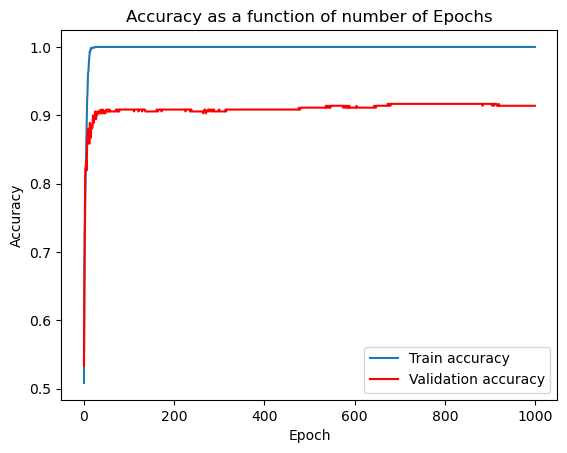

In [11]:
# your code here

eps = [i for i in range(N_eps)]
plt.plot(eps,history.history['accuracy'],label="Train accuracy")
plt.plot(eps,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

In [12]:
model_overfit.summary()

Model: "model_overfit"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 98,801
Trainable params: 98,801
Non-trainable params: 0
_________________________________________________________________


<div class='exercise-r'>

**2.3.1**  **Regularize the overfit network**

Create an ANN that doesn't overfit and use it to [compete on Kaggle](#part2kaggle).

<a id="q2.3.1"></a>
    
**DON'TS**

- **DO NOT change the architecture**. In other words, keep the same number of layers, same number of nodes, same activation function, and same loss function and output unit as was used in your question 2.2 overfit model. **No CNNs, RNNs, ensembles, or fancy enhancements.**

- **DO NOT manually label your submissions.** In other words, the labels should only be the outcome of your model.

- **DO NOT use any external data.** Please use ONLY the specific KMNIST datasets provided to you (via the CS109B [data link above](#part2data)) for training your model and for generating your test predictions.

**DOS**

 - **YOU CAN change the** number of epochs (max 2000), batch size, optimizer, and of course, add elements that can help to regularize your model (e.g., dropout, L2 norm, etc.).
 - **YOU CAN also** do data augmentation using the provided training data. 
 - **YOU CAN** add flatten layers as you see fit.

**IMPORTANT: YOU MUST** ensure that the version of the code and model in your final submitted notebook is the **EXACT SAME** code and model used to generate your Kaggle submission. TFs may run your submitted model to ensure comparable results. **Other Kaggle competition rules and scoring details [are listed here](#part2kaggle).**



</div>

## Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GaussianNoise

In [14]:
%%time
# your code here

X_train_aug = x_train.copy()
# Reshape the images to 3D tensors
X_train_aug = X_train_aug.values.reshape(-1, 28, 28, 1)

# Define the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=10,      # rotate the image up to 10 degrees
    width_shift_range=0.1,  # shift the image left or right by up to 10% of the width
    height_shift_range=0.1, # shift the image up or down by up to 10% of the height
    shear_range=0.1,        # apply shearing transformation with maximum of 10%
    zoom_range=0.1,         # zoom in or out by up to 10%
    fill_mode='nearest',    # fill the empty space with the nearest pixel value
    horizontal_flip=True,   # flip the image horizontally
    vertical_flip=True,    # do not flip the image vertically
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train_aug)

# Generate augmented images
augmented_images = np.empty((0, 28, 28, 1))
augmented_labels = np.empty((0,))

num_images = 1000

for X_batch, y_batch in datagen.flow(X_train_aug, y_train, batch_size=32):
    augmented_images = np.concatenate((augmented_images, X_batch))
    augmented_labels = np.concatenate((augmented_labels, y_batch))
    if len(augmented_images) >= num_images:
        break

# Convert the labels to integers
augmented_labels = augmented_labels.astype(int)

augmented_images = augmented_images.reshape((augmented_images.shape[0], -1))

X_train_augmented = np.concatenate((x_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_labels))

CPU times: user 383 ms, sys: 53.8 ms, total: 436 ms
Wall time: 441 ms


In [15]:
# your code here

std = 0.75

inputs = tf.keras.layers.Input(shape=(784,))
x = GaussianNoise(stddev=std, seed=109)(inputs)
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(inputs)
x = tf.keras.layers.Dense(100,activation="relu")(x)
x = tf.keras.layers.Dense(100,activation="relu")(x)
outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

NN_model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model_overfit")
NN_model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])

In [16]:
%%time
N_eps = 100
history=NN_model.fit(X_train_augmented,y_train_augmented,epochs=N_eps,batch_size=128,validation_split=0.3)

Epoch 1/100
13/13 [==============================] - 1s 14ms/step - loss: 3.8633 - accuracy: 0.5668 - val_loss: 0.6925 - val_accuracy: 0.5494
Epoch 2/100
13/13 [==============================] - 0s 5ms/step - loss: 1.0852 - accuracy: 0.6420 - val_loss: 0.6923 - val_accuracy: 0.5644
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.7179 - val_loss: 0.6917 - val_accuracy: 0.6078
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 0.5118 - accuracy: 0.7757 - val_loss: 0.6914 - val_accuracy: 0.6198
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 0.4030 - accuracy: 0.8104 - val_loss: 0.6914 - val_accuracy: 0.6003
Epoch 6/100
13/13 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8258 - val_loss: 0.6911 - val_accuracy: 0.6048
Epoch 7/100
13/13 [==============================] - 0s 4ms/step - loss: 0.3203 - accuracy: 0.8451 - val_loss: 0.6912 - val_accuracy: 0.6168
Epoch 8/100


Epoch 59/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1520 - accuracy: 0.9094 - val_loss: 0.6728 - val_accuracy: 0.5509
Epoch 60/100
13/13 [==============================] - 0s 5ms/step - loss: 0.1516 - accuracy: 0.9107 - val_loss: 0.6717 - val_accuracy: 0.5539
Epoch 61/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1512 - accuracy: 0.9107 - val_loss: 0.6702 - val_accuracy: 0.5734
Epoch 62/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1508 - accuracy: 0.9171 - val_loss: 0.6674 - val_accuracy: 0.6302
Epoch 63/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1507 - accuracy: 0.9248 - val_loss: 0.6647 - val_accuracy: 0.6587
Epoch 64/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1504 - accuracy: 0.9267 - val_loss: 0.6633 - val_accuracy: 0.6557
Epoch 65/100
13/13 [==============================] - 0s 4ms/step - loss: 0.1499 - accuracy: 0.9287 - val_loss: 0.6618 - val_accuracy: 0.6527
Epoch 

## Regularization

In [ ]:
%%time 
# your code here
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=75, 
                                            restore_best_weights=True, 
                                            verbose=1)

Cs = [10**i for i in range(-4,2)]
val_accs_l2 = []
for l in Cs:
    
    l_reg = tf.keras.regularizers.L2(l)
    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    val_accs_l2.append(max(history.history['val_accuracy']))


Epoch 1/300
7/7 [==============================] - 1s 30ms/step - loss: 16.3106 - accuracy: 0.5226 - val_loss: 5.0896 - val_accuracy: 0.5306
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 4.0529 - accuracy: 0.5071 - val_loss: 4.0474 - val_accuracy: 0.5111
Epoch 3/300
7/7 [==============================] - 0s 9ms/step - loss: 2.7520 - accuracy: 0.5024 - val_loss: 0.9354 - val_accuracy: 0.6278
Epoch 4/300
7/7 [==============================] - 0s 9ms/step - loss: 1.1951 - accuracy: 0.6214 - val_loss: 1.2438 - val_accuracy: 0.5611
Epoch 5/300
7/7 [==============================] - 0s 8ms/step - loss: 0.9957 - accuracy: 0.6405 - val_loss: 0.9520 - val_accuracy: 0.6472
Epoch 6/300
7/7 [==============================] - 0s 9ms/step - loss: 0.7127 - accuracy: 0.7262 - val_loss: 0.7437 - val_accuracy: 0.7361
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5822 - accuracy: 0.7667 - val_loss: 0.6498 - val_accuracy: 0.7667
Epoch 8/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.3352 - val_accuracy: 0.9333
Epoch 60/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 1.0000 - val_loss: 0.3316 - val_accuracy: 0.9361
Epoch 61/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.3309 - val_accuracy: 0.9361
Epoch 62/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 0.3379 - val_accuracy: 0.9333
Epoch 63/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.9333
Epoch 64/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.3450 - val_accuracy: 0.9333
Epoch 65/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0343 - accuracy: 1.0000 - val_loss: 0.3468 - val_accuracy: 0.9333
Epoch 66/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.6772 - accuracy: 0.8583 - val_loss: 0.8766 - val_accuracy: 0.7889
Epoch 9/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6316 - accuracy: 0.8821 - val_loss: 0.8164 - val_accuracy: 0.8056
Epoch 10/300
7/7 [==============================] - 0s 7ms/step - loss: 0.6007 - accuracy: 0.8917 - val_loss: 0.7625 - val_accuracy: 0.8333
Epoch 11/300
7/7 [==============================] - 0s 7ms/step - loss: 0.5685 - accuracy: 0.9083 - val_loss: 0.7363 - val_accuracy: 0.8639
Epoch 12/300
7/7 [==============================] - 0s 6ms/step - loss: 0.5264 - accuracy: 0.9417 - val_loss: 0.7515 - val_accuracy: 0.8694
Epoch 13/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4981 - accuracy: 0.9381 - val_loss: 0.8288 - val_accuracy: 0.8417
Epoch 14/300
7/7 [==============================] - 0s 6ms/step - loss: 0.4742 - accuracy: 0.9417 - val_loss: 0.7236 - val_accuracy: 0.8528
Epoch 15/300
7/7 [================

7/7 [==============================] - 0s 7ms/step - loss: 0.2798 - accuracy: 1.0000 - val_loss: 0.7321 - val_accuracy: 0.9194
Epoch 67/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2789 - accuracy: 1.0000 - val_loss: 0.7152 - val_accuracy: 0.9167
Epoch 68/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2781 - accuracy: 1.0000 - val_loss: 0.7093 - val_accuracy: 0.9083
Epoch 69/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2772 - accuracy: 1.0000 - val_loss: 0.7111 - val_accuracy: 0.9139
Epoch 70/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2764 - accuracy: 1.0000 - val_loss: 0.7189 - val_accuracy: 0.9167
Epoch 71/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2756 - accuracy: 1.0000 - val_loss: 0.7145 - val_accuracy: 0.9167
Epoch 72/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2748 - accuracy: 1.0000 - val_loss: 0.7058 - val_accuracy: 0.9083
Epoch 73/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 0.2388 - accuracy: 1.0000 - val_loss: 0.6676 - val_accuracy: 0.9222
Epoch 125/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2382 - accuracy: 1.0000 - val_loss: 0.6760 - val_accuracy: 0.9222
Epoch 126/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2376 - accuracy: 1.0000 - val_loss: 0.6744 - val_accuracy: 0.9222
Epoch 127/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2370 - accuracy: 1.0000 - val_loss: 0.6587 - val_accuracy: 0.9222
Epoch 128/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2364 - accuracy: 1.0000 - val_loss: 0.6559 - val_accuracy: 0.9194
Epoch 129/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2358 - accuracy: 1.0000 - val_loss: 0.6544 - val_accuracy: 0.9167
Epoch 130/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2352 - accuracy: 1.0000 - val_loss: 0.6549 - val_accuracy: 0.9139
Epoch 131/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.2186 - accuracy: 1.0000 - val_loss: 0.5233 - val_accuracy: 0.9167
Epoch 183/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2180 - accuracy: 1.0000 - val_loss: 0.5240 - val_accuracy: 0.9139
Epoch 184/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2174 - accuracy: 1.0000 - val_loss: 0.5248 - val_accuracy: 0.9167
Epoch 185/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2169 - accuracy: 1.0000 - val_loss: 0.5261 - val_accuracy: 0.9139
Epoch 186/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2163 - accuracy: 1.0000 - val_loss: 0.5264 - val_accuracy: 0.9167
Epoch 187/300
7/7 [==============================] - 0s 6ms/step - loss: 0.2158 - accuracy: 1.0000 - val_loss: 0.5266 - val_accuracy: 0.9167
Epoch 188/300
7/7 [==============================] - 0s 7ms/step - loss: 0.2153 - accuracy: 1.0000 - val_loss: 0.5282 - val_accuracy: 0.9139
Epoch 189/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 2.9129 - accuracy: 0.9738 - val_loss: 3.2845 - val_accuracy: 0.8333
Epoch 17/300
7/7 [==============================] - 0s 7ms/step - loss: 2.8621 - accuracy: 0.9821 - val_loss: 3.2441 - val_accuracy: 0.8306
Epoch 18/300
7/7 [==============================] - 0s 7ms/step - loss: 2.8175 - accuracy: 0.9917 - val_loss: 3.1451 - val_accuracy: 0.8639
Epoch 19/300
7/7 [==============================] - 0s 7ms/step - loss: 2.7717 - accuracy: 0.9952 - val_loss: 3.1098 - val_accuracy: 0.8750
Epoch 20/300
7/7 [==============================] - 0s 7ms/step - loss: 2.7344 - accuracy: 0.9964 - val_loss: 3.0814 - val_accuracy: 0.8750
Epoch 21/300
7/7 [==============================] - 0s 7ms/step - loss: 2.7049 - accuracy: 0.9976 - val_loss: 3.0592 - val_accuracy: 0.8611
Epoch 22/300
7/7 [==============================] - 0s 7ms/step - loss: 2.6687 - accuracy: 1.0000 - val_loss: 3.0285 - val_accuracy: 0.8639
Epoch 23/300
7/7 [===============

7/7 [==============================] - 0s 7ms/step - loss: 1.7444 - accuracy: 1.0000 - val_loss: 2.1036 - val_accuracy: 0.9000
Epoch 75/300
7/7 [==============================] - 0s 10ms/step - loss: 1.7330 - accuracy: 1.0000 - val_loss: 2.0849 - val_accuracy: 0.9028
Epoch 76/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7195 - accuracy: 1.0000 - val_loss: 2.0585 - val_accuracy: 0.9083
Epoch 77/300
7/7 [==============================] - 0s 7ms/step - loss: 1.7066 - accuracy: 1.0000 - val_loss: 2.0431 - val_accuracy: 0.9056
Epoch 78/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6942 - accuracy: 1.0000 - val_loss: 2.0290 - val_accuracy: 0.9028
Epoch 79/300
7/7 [==============================] - 0s 7ms/step - loss: 1.6820 - accuracy: 1.0000 - val_loss: 2.0176 - val_accuracy: 0.9028
Epoch 80/300
7/7 [==============================] - 0s 8ms/step - loss: 1.6697 - accuracy: 1.0000 - val_loss: 2.0105 - val_accuracy: 0.9028
Epoch 81/300
7/7 [==============

7/7 [==============================] - 0s 8ms/step - loss: 1.1987 - accuracy: 1.0000 - val_loss: 1.4945 - val_accuracy: 0.9139
Epoch 133/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1912 - accuracy: 1.0000 - val_loss: 1.4882 - val_accuracy: 0.9222
Epoch 134/300
7/7 [==============================] - 0s 8ms/step - loss: 1.1836 - accuracy: 1.0000 - val_loss: 1.4806 - val_accuracy: 0.9139
Epoch 135/300
7/7 [==============================] - 0s 8ms/step - loss: 1.1762 - accuracy: 1.0000 - val_loss: 1.4747 - val_accuracy: 0.9222
Epoch 136/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1689 - accuracy: 1.0000 - val_loss: 1.4668 - val_accuracy: 0.9139
Epoch 137/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1615 - accuracy: 1.0000 - val_loss: 1.4596 - val_accuracy: 0.9222
Epoch 138/300
7/7 [==============================] - 0s 7ms/step - loss: 1.1542 - accuracy: 1.0000 - val_loss: 1.4518 - val_accuracy: 0.9139
Epoch 139/300
7/7 [========

7/7 [==============================] - 0s 7ms/step - loss: 0.8365 - accuracy: 1.0000 - val_loss: 1.1416 - val_accuracy: 0.9139
Epoch 191/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8314 - accuracy: 1.0000 - val_loss: 1.1365 - val_accuracy: 0.9139
Epoch 192/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8263 - accuracy: 1.0000 - val_loss: 1.1317 - val_accuracy: 0.9139
Epoch 193/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8212 - accuracy: 1.0000 - val_loss: 1.1268 - val_accuracy: 0.9139
Epoch 194/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8161 - accuracy: 1.0000 - val_loss: 1.1230 - val_accuracy: 0.9111
Epoch 195/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8111 - accuracy: 1.0000 - val_loss: 1.1190 - val_accuracy: 0.9139
Epoch 196/300
7/7 [==============================] - 0s 7ms/step - loss: 0.8062 - accuracy: 1.0000 - val_loss: 1.1143 - val_accuracy: 0.9111
Epoch 197/300
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.5851 - accuracy: 1.0000 - val_loss: 0.8916 - val_accuracy: 0.9028
Epoch 249/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5815 - accuracy: 1.0000 - val_loss: 0.8873 - val_accuracy: 0.9083
Epoch 250/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5779 - accuracy: 1.0000 - val_loss: 0.8843 - val_accuracy: 0.9028
Epoch 251/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5743 - accuracy: 1.0000 - val_loss: 0.8797 - val_accuracy: 0.9056
Epoch 252/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5708 - accuracy: 1.0000 - val_loss: 0.8759 - val_accuracy: 0.9056
Epoch 253/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5673 - accuracy: 1.0000 - val_loss: 0.8720 - val_accuracy: 0.9028
Epoch 254/300
7/7 [==============================] - 0s 8ms/step - loss: 0.5638 - accuracy: 1.0000 - val_loss: 0.8684 - val_accuracy: 0.9056
Epoch 255/300
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 27.3474 - accuracy: 0.8905 - val_loss: 26.5772 - val_accuracy: 0.8306
Epoch 7/300
7/7 [==============================] - 0s 8ms/step - loss: 25.7638 - accuracy: 0.9119 - val_loss: 25.0805 - val_accuracy: 0.8333
Epoch 8/300
7/7 [==============================] - 0s 8ms/step - loss: 24.2880 - accuracy: 0.9393 - val_loss: 23.6582 - val_accuracy: 0.8694
Epoch 9/300
7/7 [==============================] - 0s 9ms/step - loss: 22.9445 - accuracy: 0.9536 - val_loss: 22.3997 - val_accuracy: 0.8889
Epoch 10/300
7/7 [==============================] - 0s 9ms/step - loss: 21.7193 - accuracy: 0.9690 - val_loss: 21.2808 - val_accuracy: 0.8917
Epoch 11/300
7/7 [==============================] - 0s 9ms/step - loss: 20.6372 - accuracy: 0.9548 - val_loss: 20.1750 - val_accuracy: 0.8972
Epoch 12/300
7/7 [==============================] - 0s 8ms/step - loss: 19.5680 - accuracy: 0.9821 - val_loss: 19.1878 - val_accuracy: 0.9056
Epoch 13/300
7/7 [====

7/7 [==============================] - 0s 8ms/step - loss: 3.0355 - accuracy: 0.9714 - val_loss: 3.0663 - val_accuracy: 0.9389
Epoch 65/300
7/7 [==============================] - 0s 8ms/step - loss: 2.9207 - accuracy: 0.9821 - val_loss: 2.9942 - val_accuracy: 0.9333
Epoch 66/300
7/7 [==============================] - 0s 8ms/step - loss: 2.8154 - accuracy: 0.9952 - val_loss: 2.9493 - val_accuracy: 0.9306
Epoch 67/300
7/7 [==============================] - 0s 8ms/step - loss: 2.7369 - accuracy: 0.9952 - val_loss: 2.8586 - val_accuracy: 0.9417
Epoch 68/300
7/7 [==============================] - 0s 8ms/step - loss: 2.6623 - accuracy: 0.9964 - val_loss: 2.7749 - val_accuracy: 0.9389
Epoch 69/300
7/7 [==============================] - 0s 8ms/step - loss: 2.5862 - accuracy: 1.0000 - val_loss: 2.7054 - val_accuracy: 0.9333
Epoch 70/300
7/7 [==============================] - 0s 8ms/step - loss: 2.5158 - accuracy: 1.0000 - val_loss: 2.6413 - val_accuracy: 0.9361
Epoch 71/300
7/7 [===============

7/7 [==============================] - 0s 8ms/step - loss: 0.7806 - accuracy: 1.0000 - val_loss: 0.9254 - val_accuracy: 0.9417
Epoch 123/300
7/7 [==============================] - 0s 8ms/step - loss: 0.7674 - accuracy: 1.0000 - val_loss: 0.9075 - val_accuracy: 0.9417
Epoch 124/300
7/7 [==============================] - 0s 8ms/step - loss: 0.7533 - accuracy: 1.0000 - val_loss: 0.9242 - val_accuracy: 0.9361
Epoch 125/300
7/7 [==============================] - 0s 8ms/step - loss: 0.7426 - accuracy: 1.0000 - val_loss: 0.8868 - val_accuracy: 0.9444
Epoch 126/300
7/7 [==============================] - 0s 8ms/step - loss: 0.7258 - accuracy: 1.0000 - val_loss: 0.8675 - val_accuracy: 0.9417
Epoch 127/300
7/7 [==============================] - 0s 8ms/step - loss: 0.7109 - accuracy: 1.0000 - val_loss: 0.8526 - val_accuracy: 0.9444
Epoch 128/300
7/7 [==============================] - 0s 8ms/step - loss: 0.6985 - accuracy: 1.0000 - val_loss: 0.8385 - val_accuracy: 0.9444
Epoch 129/300
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.3172 - accuracy: 1.0000 - val_loss: 0.4641 - val_accuracy: 0.9444
Epoch 181/300
7/7 [==============================] - 0s 8ms/step - loss: 0.3137 - accuracy: 1.0000 - val_loss: 0.4622 - val_accuracy: 0.9417
Epoch 182/300
7/7 [==============================] - 0s 8ms/step - loss: 0.3073 - accuracy: 1.0000 - val_loss: 0.4566 - val_accuracy: 0.9444
Epoch 183/300
7/7 [==============================] - 0s 8ms/step - loss: 0.3026 - accuracy: 1.0000 - val_loss: 0.4521 - val_accuracy: 0.9444
Epoch 184/300
7/7 [==============================] - 0s 8ms/step - loss: 0.2982 - accuracy: 1.0000 - val_loss: 0.4486 - val_accuracy: 0.9472
Epoch 185/300
7/7 [==============================] - 0s 8ms/step - loss: 0.2943 - accuracy: 1.0000 - val_loss: 0.4554 - val_accuracy: 0.9417
Epoch 186/300
7/7 [==============================] - 0s 8ms/step - loss: 0.2908 - accuracy: 1.0000 - val_loss: 0.4416 - val_accuracy: 0.9417
Epoch 187/300
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.1482 - accuracy: 1.0000 - val_loss: 0.3302 - val_accuracy: 0.9389
Epoch 239/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1480 - accuracy: 1.0000 - val_loss: 0.3109 - val_accuracy: 0.9444
Epoch 240/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1490 - accuracy: 1.0000 - val_loss: 0.3488 - val_accuracy: 0.9167
Epoch 241/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1577 - accuracy: 1.0000 - val_loss: 0.4347 - val_accuracy: 0.9111
Epoch 242/300
7/7 [==============================] - 0s 8ms/step - loss: 3.3225 - accuracy: 0.7583 - val_loss: 1.3241 - val_accuracy: 0.4944
Epoch 243/300
7/7 [==============================] - 0s 8ms/step - loss: 0.9397 - accuracy: 0.5214 - val_loss: 0.9319 - val_accuracy: 0.5250
Epoch 244/300
7/7 [==============================] - 0s 7ms/step - loss: 0.9671 - accuracy: 0.5250 - val_loss: 1.0209 - val_accuracy: 0.4944
Epoch 245/300
7/7 [========

7/7 [==============================] - 0s 8ms/step - loss: 0.1585 - accuracy: 1.0000 - val_loss: 0.2967 - val_accuracy: 0.9472
Epoch 297/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1555 - accuracy: 1.0000 - val_loss: 0.2937 - val_accuracy: 0.9472
Epoch 298/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1528 - accuracy: 1.0000 - val_loss: 0.2899 - val_accuracy: 0.9472
Epoch 299/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1501 - accuracy: 1.0000 - val_loss: 0.2888 - val_accuracy: 0.9472
Epoch 300/300
7/7 [==============================] - 0s 8ms/step - loss: 0.1488 - accuracy: 1.0000 - val_loss: 0.2857 - val_accuracy: 0.9472
Epoch 1/300
7/7 [==============================] - 2s 39ms/step - loss: 367.8752 - accuracy: 0.5429 - val_loss: 340.5587 - val_accuracy: 0.6167
Epoch 2/300
7/7 [==============================] - 0s 10ms/step - loss: 325.8369 - accuracy: 0.6214 - val_loss: 302.4376 - val_accuracy: 0.6889
Epoch 3/300
7/7 [====

In [ ]:
val_accs_l1 = []
for l in Cs:
    l_reg = tf.keras.regularizers.L1(l)
    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    val_accs_l1.append(max(history.history['val_accuracy']))

In [ ]:
regularization_dic = {'Regularization Method':['L1', 'L2'], 
                     'Max Validation Accuracy':[max(val_accs_l1), max(val_accs_l2)],
                     'Value of C':[Cs[val_accs_l1.index(max(val_accs_l1))], 
                                   Cs[val_accs_l2.index(max(val_accs_l2))]]}

pd.DataFrame.from_dict(regularization_dic).set_index('Regularization Method')

## Dropout

In [ ]:
C = 0.1
l_reg = tf.keras.regularizers.L1(C)

In [ ]:
# your code here
Ds = [0.05,0.1,0.2,0.3,0.4]
val_accs_drops = []
for d in Ds:    
    inputs = tf.keras.layers.Input(shape=(784,))
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
    x = tf.keras.layers.Dropout(d)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dropout(d)(x)
    x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
    x = tf.keras.layers.Dropout(d)(x)

    outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
    history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
    val_accs_drops.append(max(history.history['val_accuracy']))

In [ ]:
top = max(val_accs_drops)
d_rate = val_accs_drops.index(top)
print("The best dropout rate is: {}, achieving a validation accuracy of {}".format(Ds[d_rate],val_accs_drops[d_rate]))

In [ ]:
d_rate=0.2

combi_drops = []
    
inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
combi_drops.append(max(history.history['val_accuracy']))

inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
#x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
#x = tf.keras.layers.Dropout(d_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
combi_drops.append(max(history.history['val_accuracy']))

inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
#x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
#x = tf.keras.layers.Dropout(d_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )
combi_drops.append(max(history.history['val_accuracy']))

In [ ]:
combi_drops

## Batch Normalization

In [ ]:
l_reg = tf.keras.regularizers.L1(0.1)
d_rate = 0.2
activation='relu'

inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(d_rate)(x)

x = tf.keras.layers.Dense(100,kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation)(x)
x = tf.keras.layers.Dropout(d_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=300,batch_size=128,validation_split=0.3,callbacks = callback )

In [ ]:
print(max(history.history['val_accuracy']))

## Changing patience / epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, verbose=1)

inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(x_train,y_train,epochs=2000,batch_size=128,validation_split=0.3,callbacks = callback )

In [ ]:
print(max(history.history['val_accuracy']))

## Data Augmentation

In [ ]:
def add_noise(img):
    VARIABILITY = 10 # customize this
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=add_noise,
)

In [ ]:
x = np.reshape(x_train.iloc[10].values,(28,28))
x = x.reshape((1,) + x.shape + (1,))
l=datagen_aug.flow(x, batch_size=1)[0]
plt.imshow(tf.keras.preprocessing.image.array_to_img(l[0]).convert('L'), cmap='gray')
plt.show()

In [ ]:
plt.imshow(np.reshape(x_train.loc[10].values,(28,28)),cmap="gray")
plt.show()

In [ ]:
new_xs = []
new_ys = []
N = 10 #Number of newly generated images per existing ones
for i in range(len(x_train)):
    x = np.reshape(x_train.iloc[i].values,(28,28))
    x = x.reshape((1,) + x.shape + (1,))
    l=datagen_aug.flow(x, batch_size=1)
    
    cou=0
    j = []
    for k in l: 
        new_x = np.reshape(k,(784,))
        new_xs.append(new_x)
        new_ys.append(y_train.iloc[i])
        cou+=1
        if cou==N: break

In [ ]:
x = np.reshape(x_train.iloc[1].values,(28,28))
x = x.reshape((1,) + x.shape + (1,))
l=datagen_aug.flow(x, batch_size=1)
i=0
j = []
for k in l: 
    j.append(k)
    i+=1
    if i==20: break

In [ ]:
plt.imshow(np.reshape(j[15],(28,28)),cmap='gray');

In [ ]:
plt.imshow(np.reshape(x_train.iloc[1].values,(28,28)),cmap='gray');

In [ ]:
x_train2 = x_train.copy()
for x in new_xs: 
    x_train2.loc[len(x_train2)] = x
    
y_train2 = y_train.copy()
for y in new_ys: 
    y_train2.loc[len(y_train2)] = y

In [ ]:
patience = 200

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
l_reg = tf.keras.regularizers.L1(C)
d_rate = 0.2

epochs = 2000

std = 0.75

inputs = tf.keras.layers.Input(shape=(784,))
x = GaussianNoise(stddev=std, seed=109)(inputs)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(inputs)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)
x = tf.keras.layers.Dense(100,activation="relu",kernel_regularizer=l_reg,bias_regularizer=l_reg)(x)
x = tf.keras.layers.Dropout(d_rate)(x)

outputs = tf.keras.layers.Dense(1,activation="sigmoid")(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name="model")
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='binary_crossentropy',metrics=["accuracy"])
history=model.fit(X_train_augmented,y_train_augmented,epochs=epochs,batch_size=128,validation_split=0.3,callbacks = callback )

In [ ]:
print(max(history.history['val_accuracy']))

In [ ]:
y_test = model.predict(x_test)
preds = [int(np.round(i[0])) for i in y_test]
out = pd.DataFrame({'id':x_test.index, 'category':preds})

In [ ]:
out.to_csv("hw3_kaggle_V1.csv", index=False)

<div class='exercise-r'>

**2.3.2**  Plot your model's training accuracy and validation accuracy as a function of epochs.




</div>

In [ ]:
# your code here
# your code here
eps = [i for i in range(N_eps)]
plt.plot(eps,history.history['accuracy'],label="Train accuracy")
plt.plot(eps,history.history['val_accuracy'],label="Validation accuracy", color='red')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of number of Epochs")
plt.show()

<div class='exercise-r'>

**2.3.3**  In a few sentences, describe the various approaches you have taken to improve the performance of your regularized model in 2.3.1 as well as any observations you might have regarding your training and Kaggle results.


</div>

_Type your answer here, replacing this text._

<div class='exercise-r'>

**2.3.4**  Generate your test-set class predictions using your regularized model. Save those predictions to a `.csv` formatted file. Submit that `.csv` file [to the CS109B Kaggle Competition](#part2kaggle) for leaderboard scoring. **IMPORTANT:** For Kaggle to accept and score your submitted `.csv` file, it MUST contain 2 columns. The first column must be named `"Id"` and needs to contain the test observation index numbers corresponding to each of your 2,000 predictions (index starting at `0`), the second column must be named `"Category"` and needs to contain your class predictions (i.e. `0` or `1`) for each corresponding test observation index location. Both columns should contain integer data types.




</div>

In [ ]:
# your code here
...

<div class='exercise-r'>

**2.3.5**  **Specify your Kaggle name that you have used on the leaderboard**. We CANNOT give you credit without this.

</div>

_Type your answer here, replacing this text._

<!-- BEGIN QUESTION -->

<div class='exercise-r'><b>2.4 Wrap-up</b></div>

* In a few sentences, please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

_Type your answer here, replacing this text._

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("q2.4")

In [ ]:
time_end = time.time()
print(f"It took {(time_end - time_start)/60:.2f} minutes for this notebook to run")

**This concludes HW3. Thank you!**